In [1]:
import tensorflow as tf

In [2]:
import os
import sys
import collections

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

In [5]:
from rl import action_learner

In [6]:
from rl import value_estimator

In [7]:
from progress_learner import EventProgressEstimator

In [8]:
import config
import project
# Need to add this import to load class
from project import Project

In [9]:
from importlib import reload

In [10]:
# To load this, I have to add pickle.load(f, encoding='latin-1')
# Otherwise it would give the bug
# https://stackoverflow.com/questions/21129020/how-to-fix-unicodedecodeerror-ascii-codec-cant-decode-byte
p = project.Project.load("../slidearound_hopstep_1.proj")

In [11]:
reload(config)
    
c = config.Config()

In [12]:
from rl import block_movement_env

In [48]:
reload(action_learner)


<module 'rl.action_learner' from 'D:\\git\\learn-to-perform\\rl\\action_learner.py'>

In [77]:
reload(value_estimator)

<module 'rl.value_estimator' from 'D:\\git\\learn-to-perform\\rl\\value_estimator.py'>

In [33]:
p.speed

0.083696821297196897

In [13]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Test progress_estimator in a simulator

In [518]:
reload(block_movement_env)
tf.reset_default_graph()

sess =  tf.Session()

with tf.variable_scope("model") as scope:
    print('-------- Load progress model ---------')
    progress_estimator = EventProgressEstimator(is_training=False, name = p.name, config = c)  

saver = tf.train.Saver()
saver.restore(sess, '../progress.mod')

env = block_movement_env.BlockMovementEnv(c, p.speed, name = 'SlideAround', 
                       progress_estimator = progress_estimator, session = sess)

-------- Load progress model ---------
self.inputs.shape = (?, 20, 100)  after linear layer
output.shape = (10, 100) after LSTM
self.output.shape = (10,) after linear
self._targets.shape = (?,) 
INFO:tensorflow:Restoring parameters from ../progress.mod


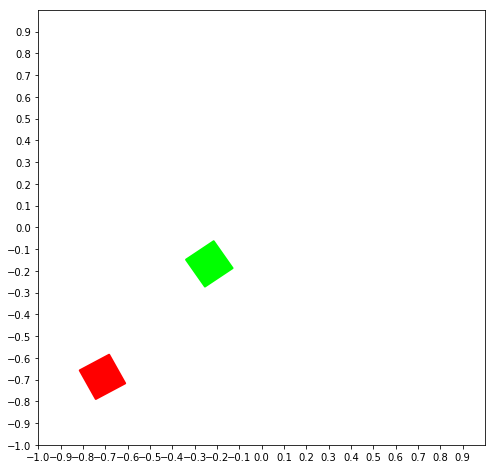

In [519]:
env.default()
env.render()

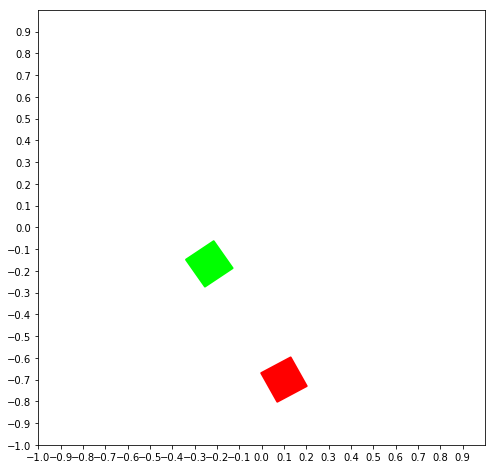

{'session_obj_2d': {0: [Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.6531825  -0.68842814  0.5       ], Cube : [-0.56949556 -0.6897139   0.5       ], Cube : [-0.48580861 -0.69099966  0.5       ], Cube : [-0.40212167 -0.69228542  0.5       ], Cube : [-0.31843472 -0.69357119  0.5       ], Cube : [-0.23474778 -0.69485695  0.5       ], Cube : [-0.15106083 -0.69614271  0.5       ], Cube : [-0.06737389 -0.69742847  0.5       ], Cube : [ 0.01631306 -0.69871424  0.5       ], Cube : [ 0.1 -0.7  0.5]], 1: [Cube : [-0.2344808  -0.167

In [520]:
env.step((0, [0.1, -0.7, 0.5], None, None))
env.render()
last_num_steps_frames = env.capture_last(21)
print (last_num_steps_frames)

inputs = env._get_features(last_num_steps_frames)[-20:]
print (inputs)

print (env.get_observation_and_progress() )

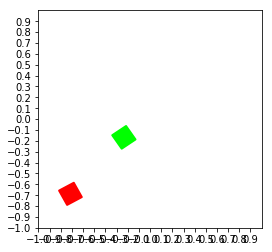

(None, None)
[ 0.1 -0.7  0.5]
Progress = 0.01


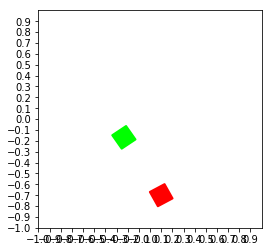

(None, None)
[ 0.2 -0.2  0.5]
Progress = 0.21


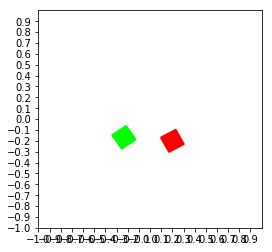

(None, None)
[-0.17  0.08  0.5 ]
Progress = 0.45


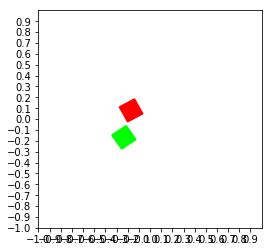

(None, None)
[-0.3  0.   0.5]
Progress = 0.49


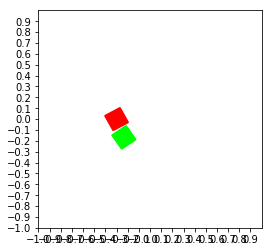

In [525]:
env.replay()

## Run reinforce algorithm

In [682]:
reload(config)
    
c = config.Config()
c.num_episodes = 100
c.constraint_sigma = 0
reload(block_movement_env)
reload(value_estimator)
reload(action_learner)
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

sess =  tf.Session()

policy_est = value_estimator.PolicyEstimator(c)
value_est = value_estimator.ValueEstimator(c)

sess.run(tf.global_variables_initializer())

with tf.variable_scope("model") as scope:
    print('-------- Load progress model ---------')
    progress_estimator = EventProgressEstimator(is_training=False, name = p.name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'))
saver.restore(sess, '../progress.mod')

action_ln = action_learner.ActionLearner(c, p, progress_estimator, 
                               policy_est, value_est, session = sess)

action_policy = action_learner.random_action
past_envs, stats = action_ln.policy_learn(action_policy, breadth = 1, verbose = False,
                                          choice = 'ACTOR_CRITIC', default = True)

-------- Load progress model ---------
self.inputs.shape = (?, 20, 100)  after linear layer
output.shape = (10, 100) after LSTM
self.output.shape = (10,) after linear
self._targets.shape = (?,) 
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
INFO:tensorflow:Restoring parameters from ../progress.mod
Step 9 @ Episode 100/100 (0.29264037730172276)

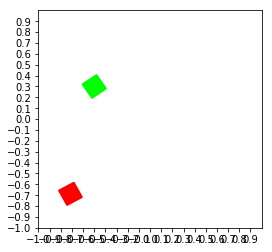

In [681]:
past_envs[20].env.replay()

In [492]:
past_envs[50].env.back()
past_envs[50].env.back()

True

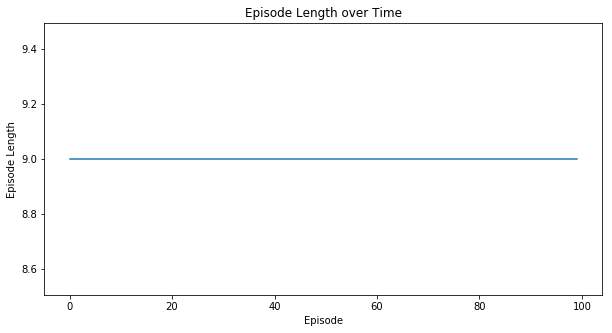

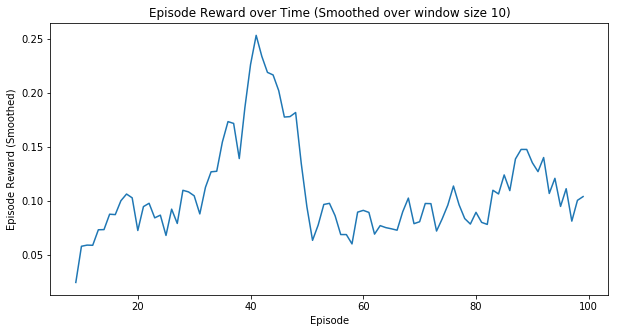

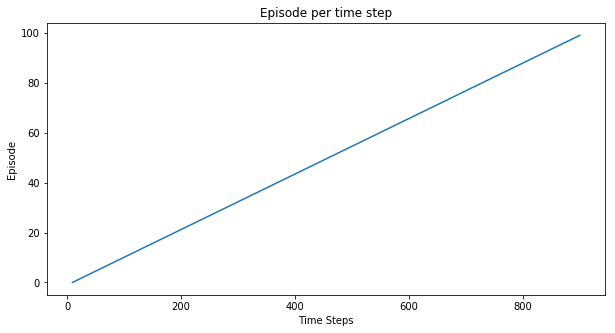

(<matplotlib.figure.Figure at 0x215ade67f60>,
 <matplotlib.figure.Figure at 0x215b713ca58>)

In [683]:
plotting.plot_episode_stats(stats, smoothing_window=10)

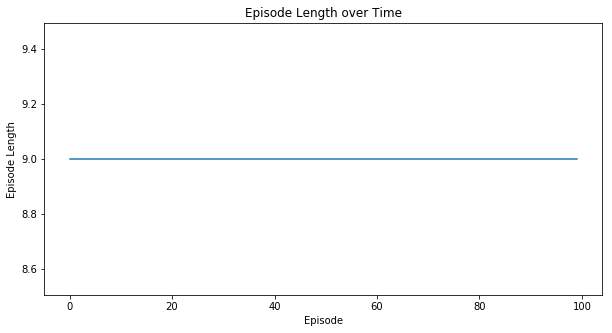

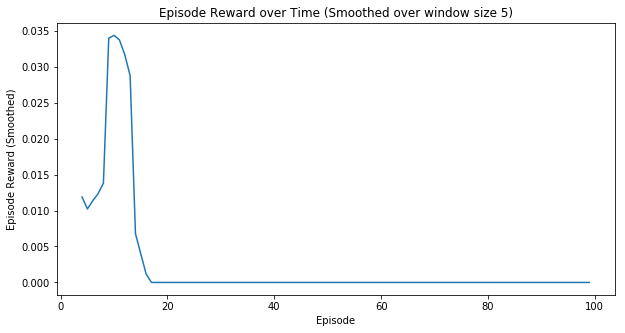

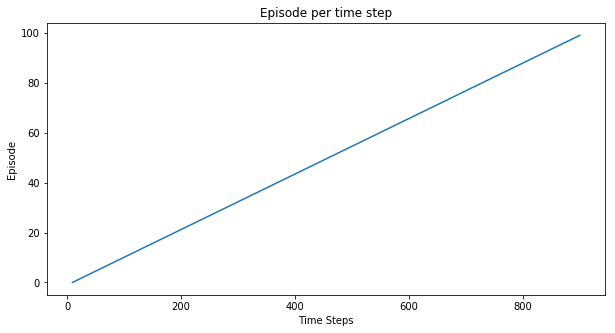

(<matplotlib.figure.Figure at 0x2152c82a940>,
 <matplotlib.figure.Figure at 0x215163c54e0>)

In [679]:
plotting.plot_episode_stats(stats, smoothing_window=5)

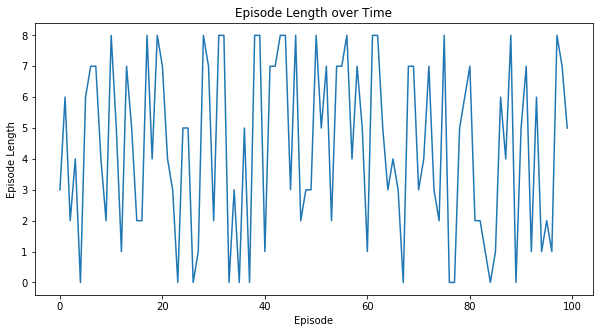

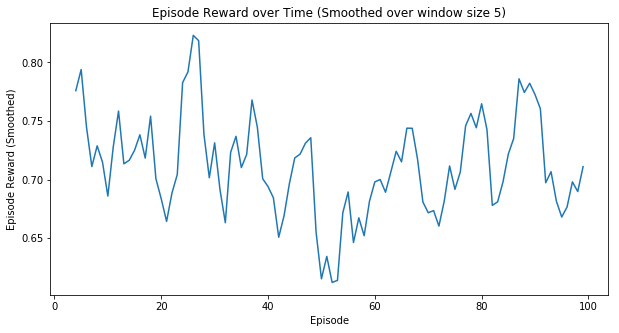

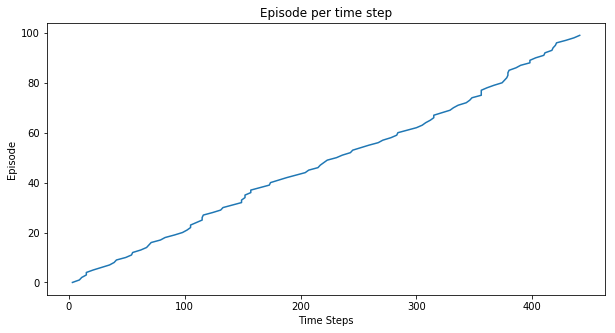

(<matplotlib.figure.Figure at 0x21515c3ec18>,
 <matplotlib.figure.Figure at 0x2151568a2b0>)

In [331]:
plotting.plot_episode_stats(stats, smoothing_window=5)

In [50]:
print (plotting.__file__)

D:\git\learn-to-perform\notebooks\plotting.py


In [245]:
import pickle

In [53]:
from plotting import EpisodeStats

In [57]:
with open('session.dat', 'rb') as f:
    stats = pickle.load(f, encoding='latin-1')

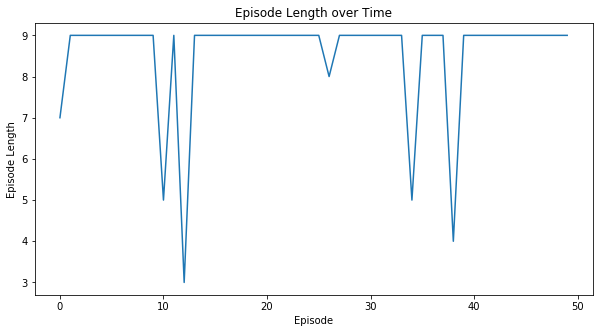

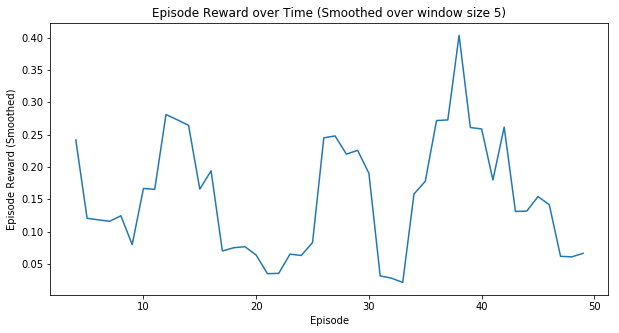

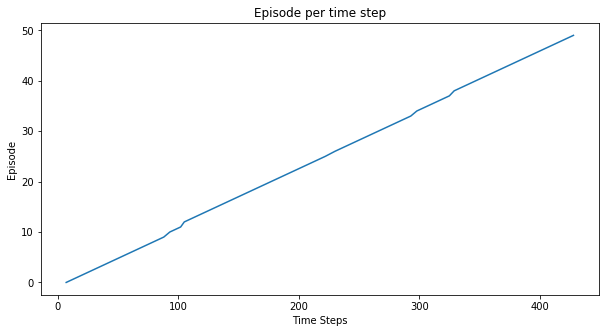

(<matplotlib.figure.Figure at 0x1cfb650a828>,
 <matplotlib.figure.Figure at 0x1cfb770cd68>)

In [58]:
plotting.plot_episode_stats(stats, smoothing_window=5)

In [84]:
with open('session.500.dat', 'rb') as f:
    stats = pickle.load(f, encoding='latin-1')

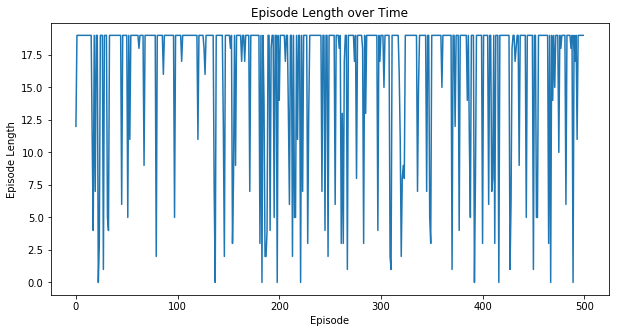

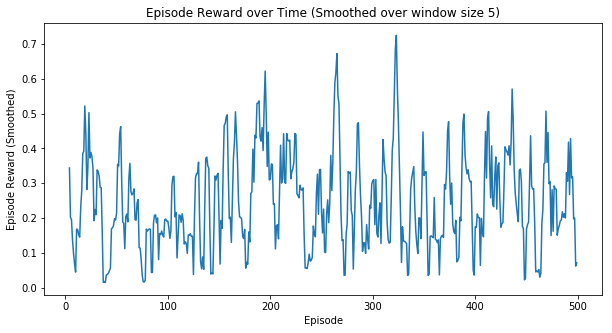

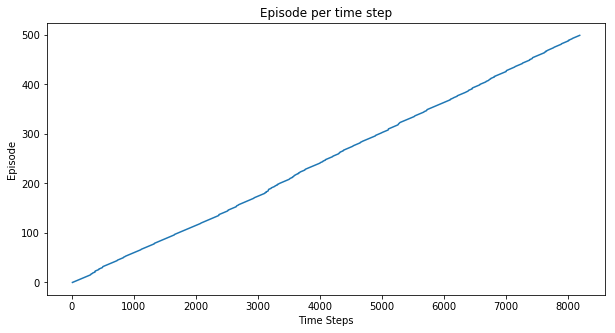

(<matplotlib.figure.Figure at 0x1cfc7e5d710>,
 <matplotlib.figure.Figure at 0x1cfc8087e80>)

In [85]:
plotting.plot_episode_stats(stats, smoothing_window=5)

In [266]:
import glob

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0020_0.9500


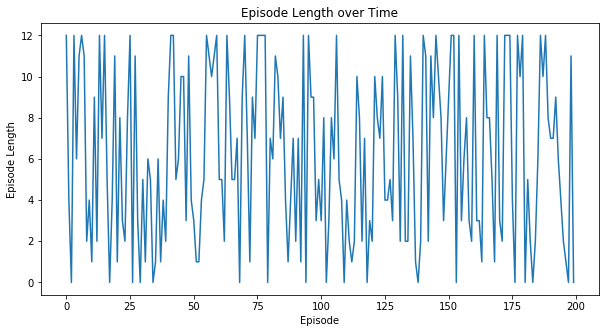

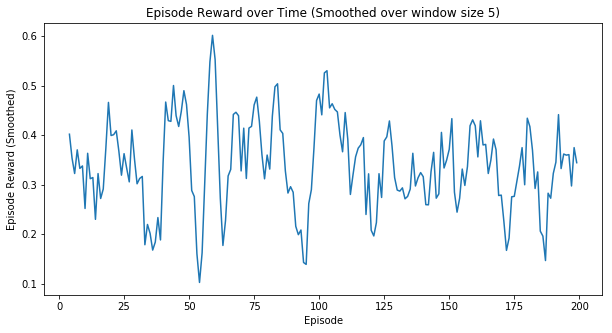

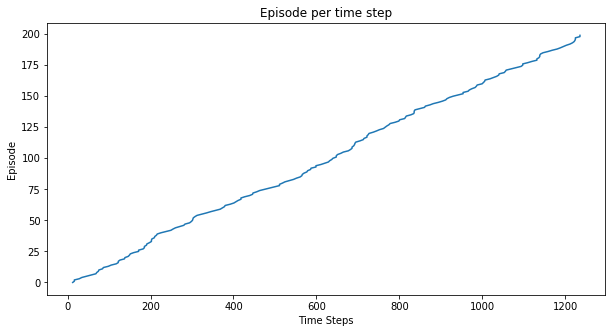

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0020_0.9600


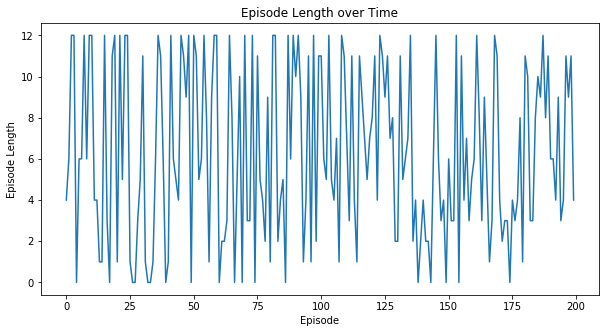

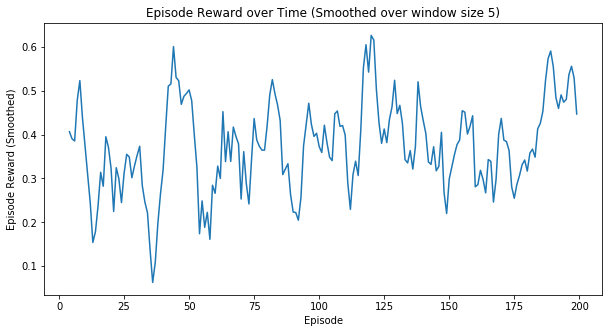

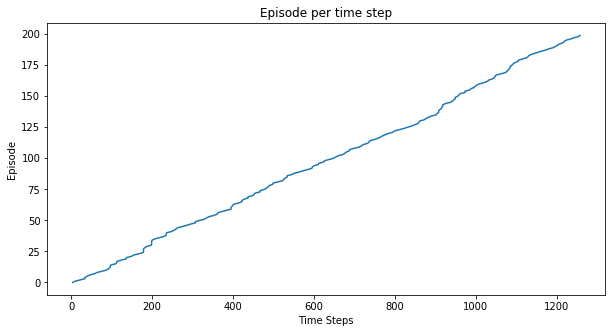

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0020_0.9700


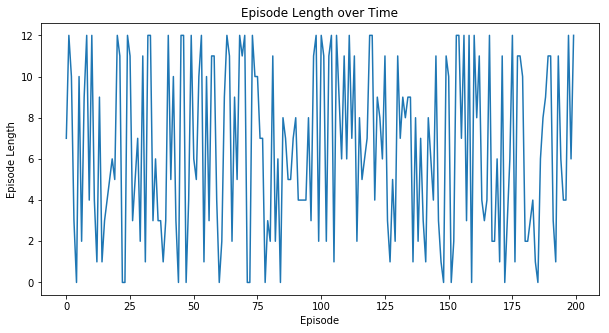

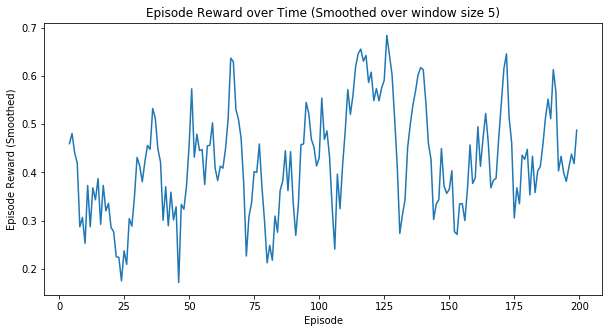

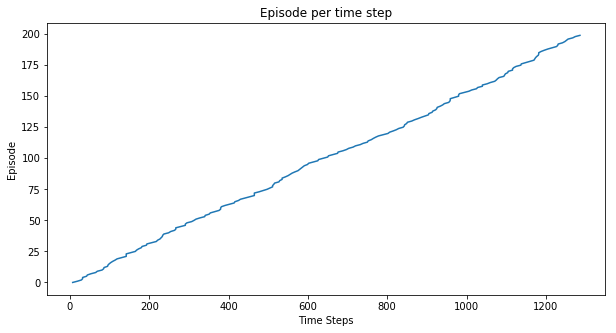

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0200_0.9500


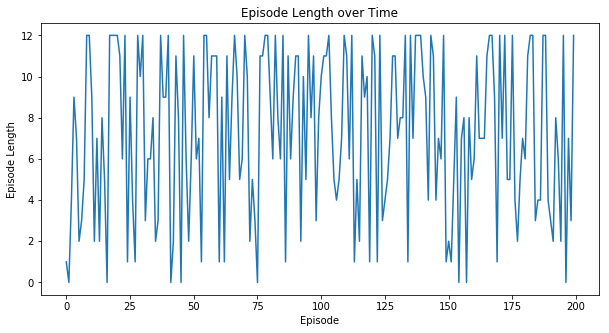

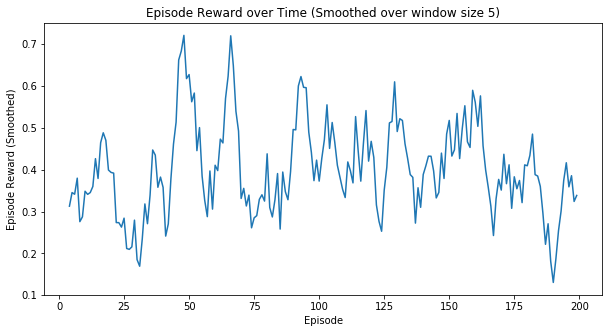

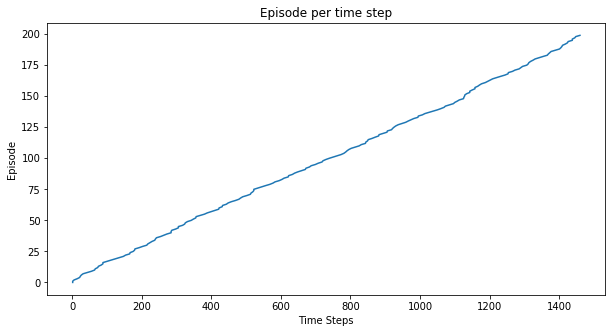

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0200_0.9600


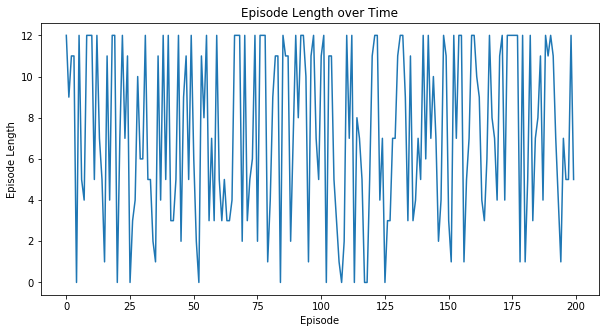

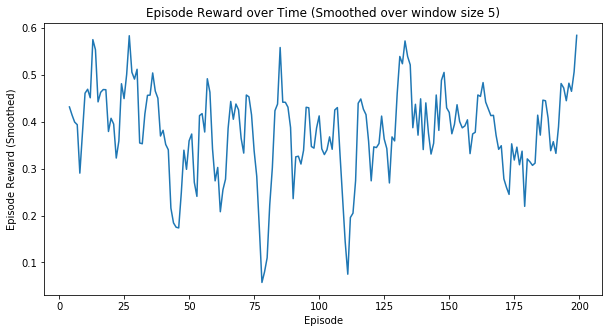

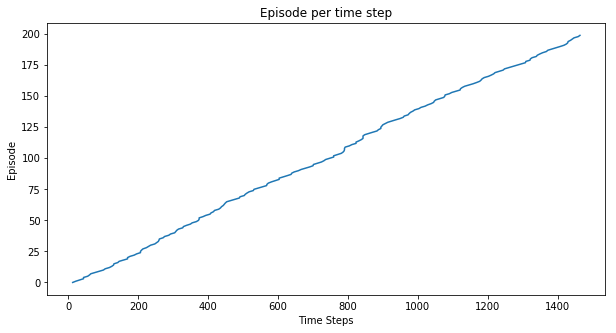

..\session_data_actor_critic\session.data._0.0020_0.9500_0.0200_0.9700


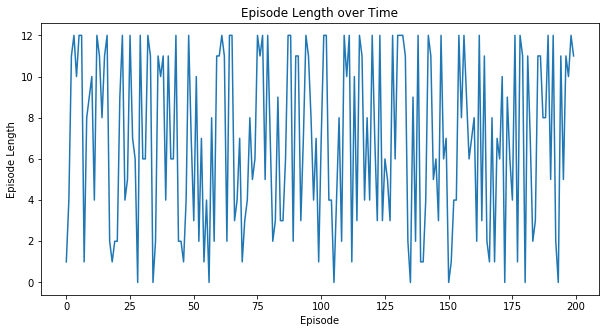

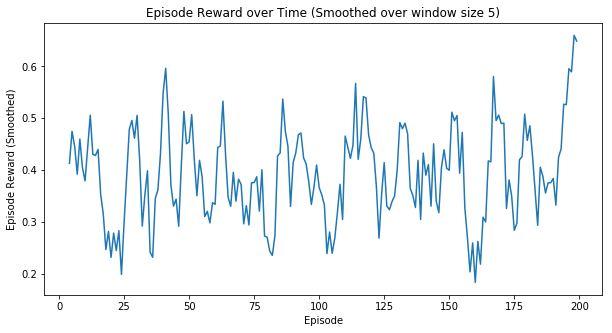

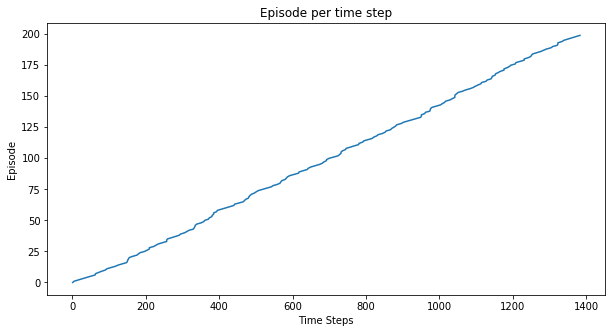

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0020_0.9500


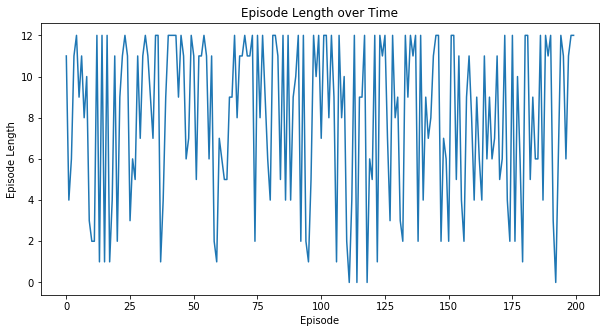

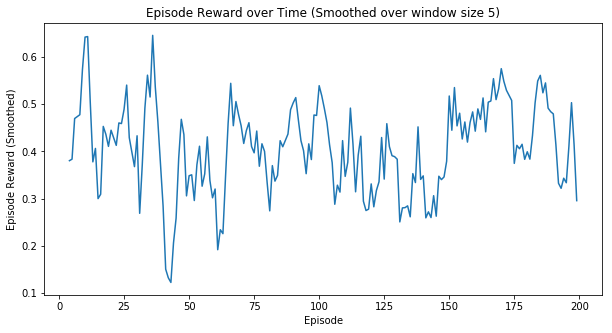

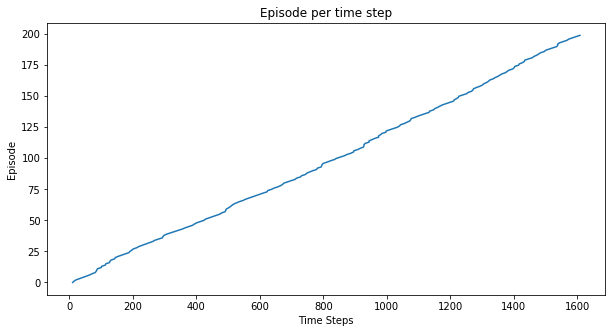

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0020_0.9600


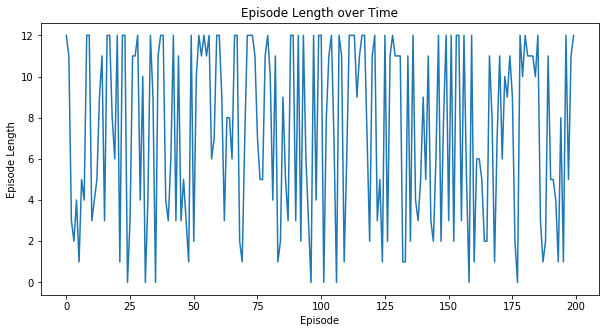

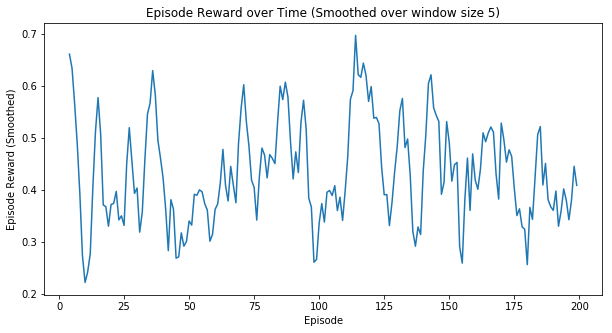

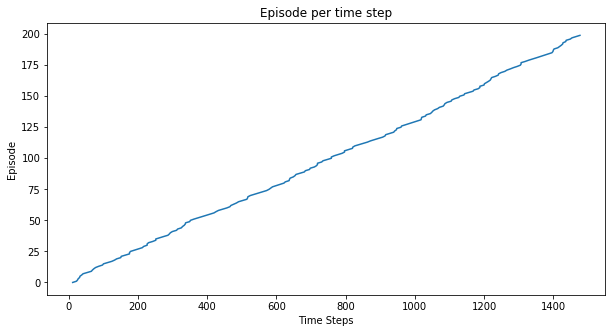

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0020_0.9700


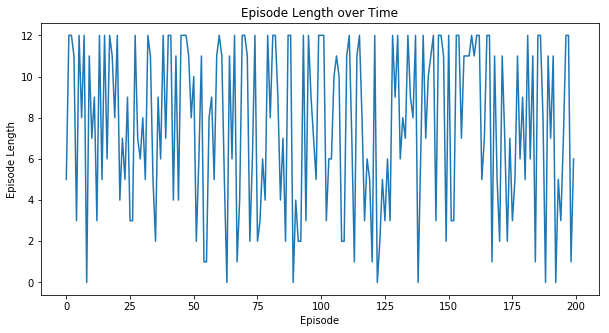

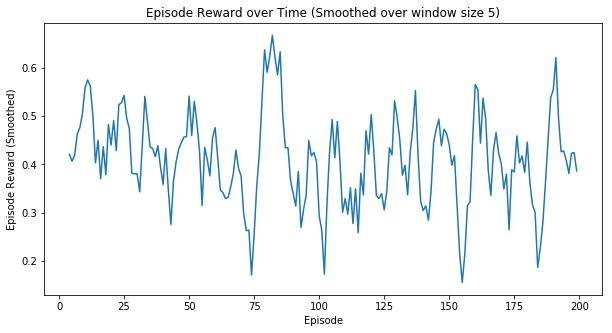

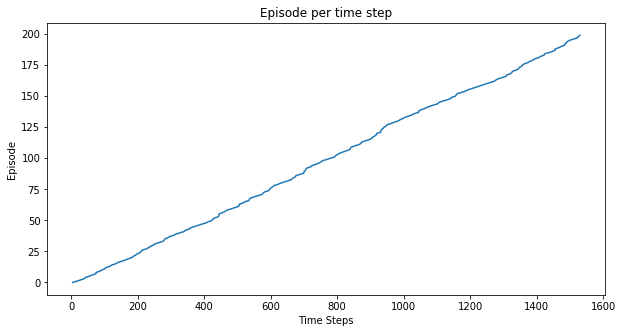

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0200_0.9500


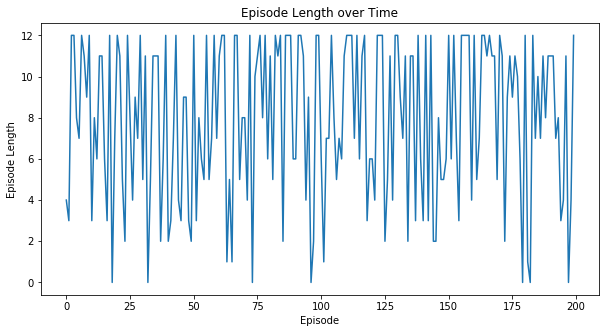

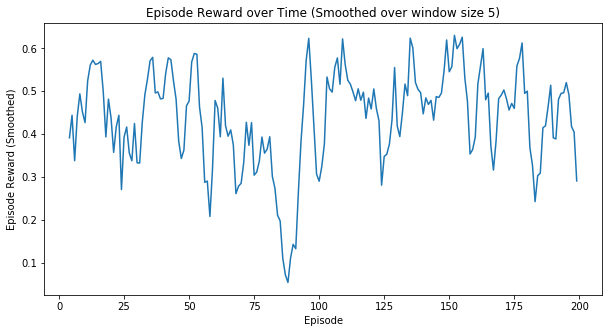

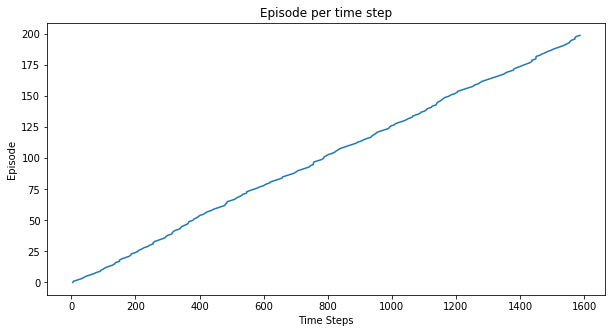

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0200_0.9600


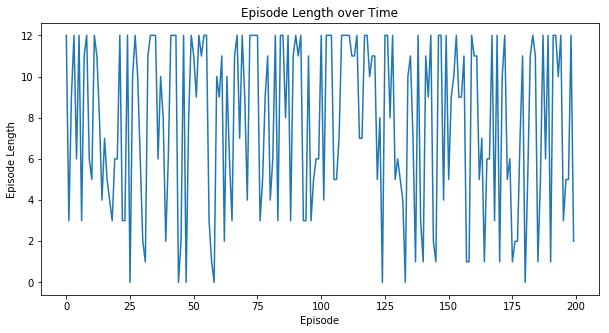

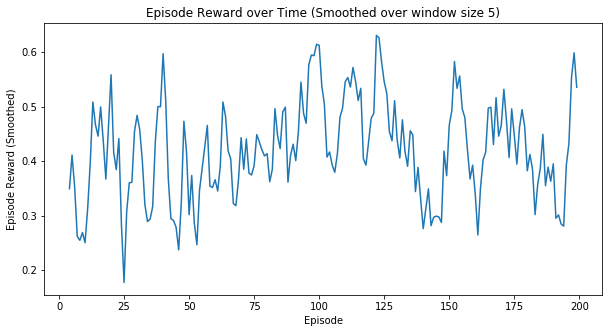

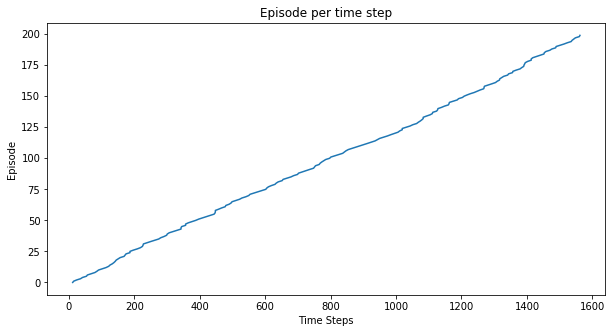

..\session_data_actor_critic\session.data._0.0020_0.9600_0.0200_0.9700


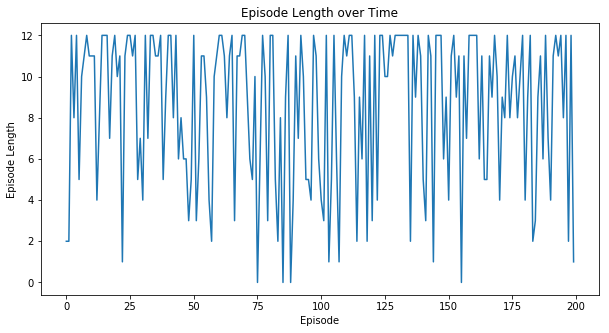

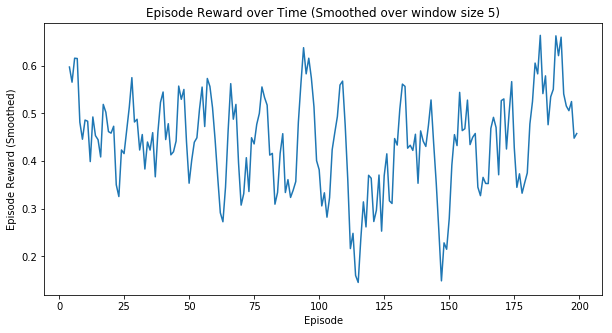

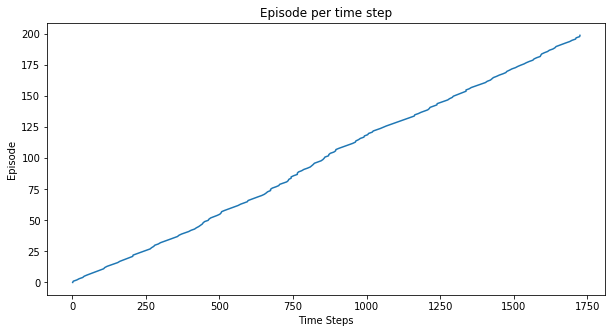

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0020_0.9500


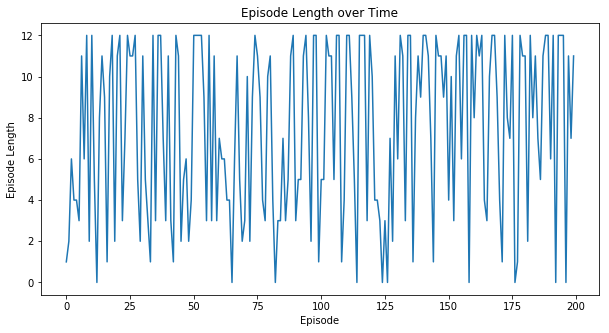

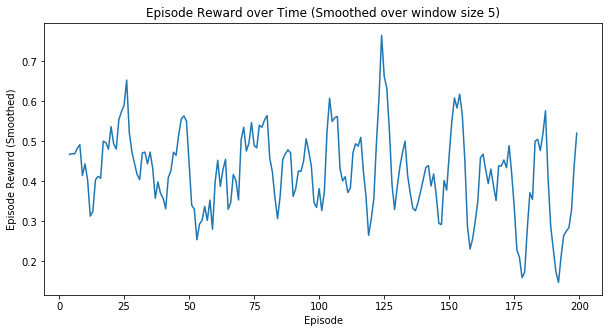

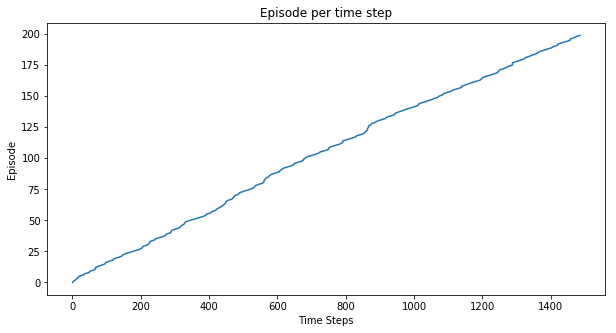

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0020_0.9600


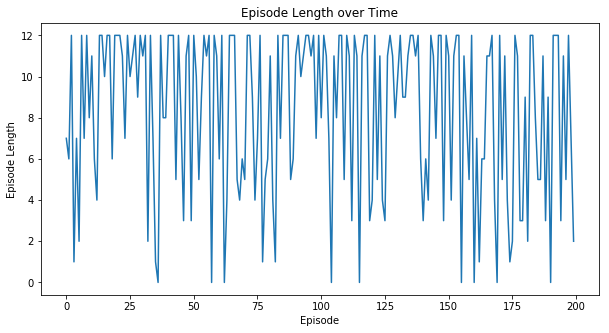

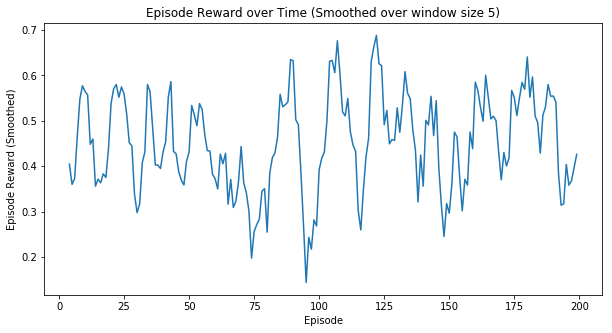

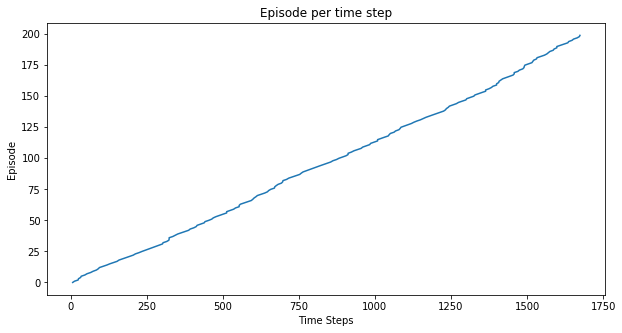

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0020_0.9700


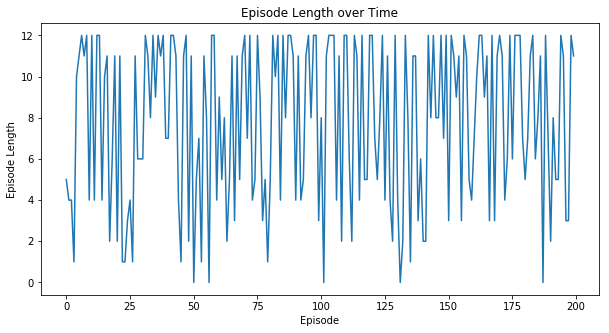

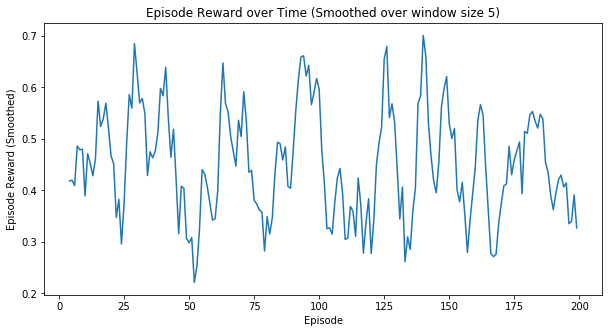

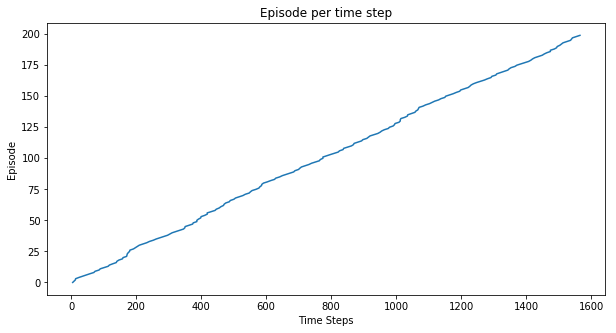

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0200_0.9500


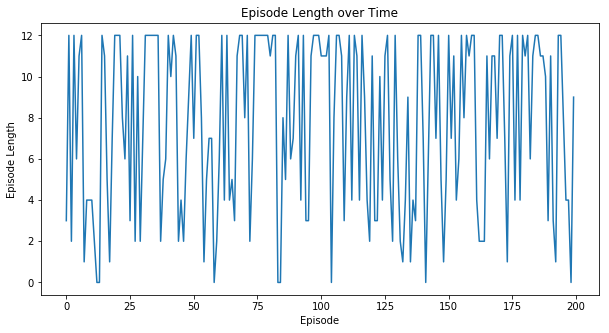

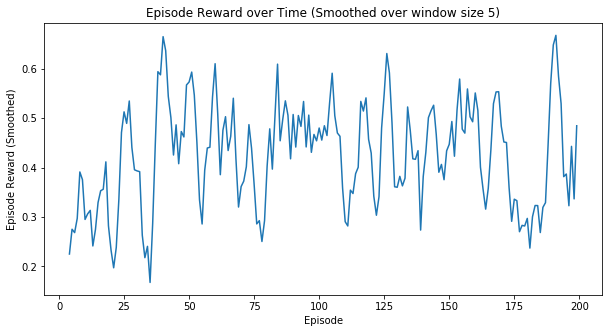

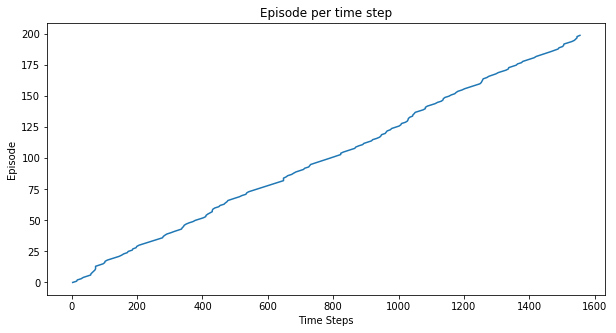

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0200_0.9600


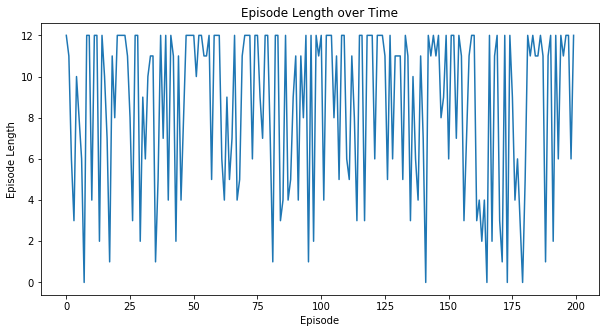

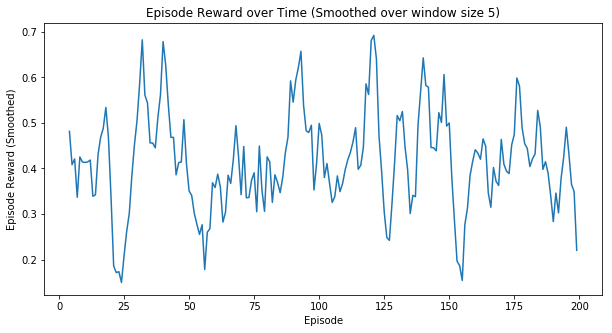

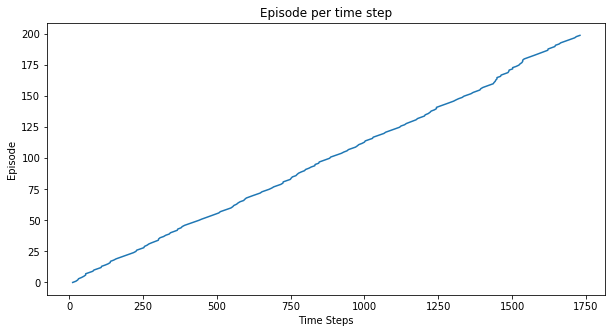

..\session_data_actor_critic\session.data._0.0020_0.9700_0.0200_0.9700


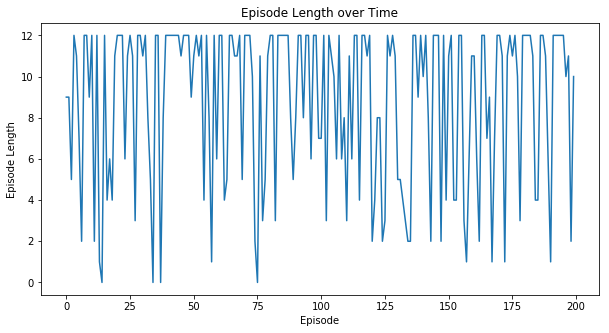

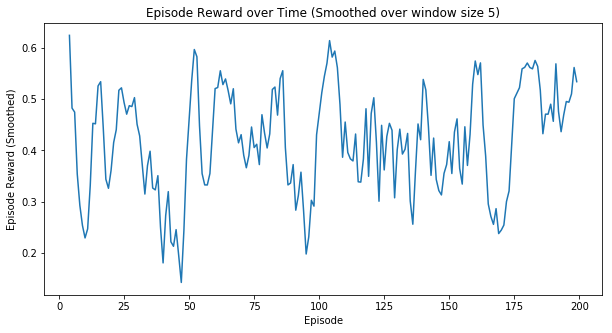

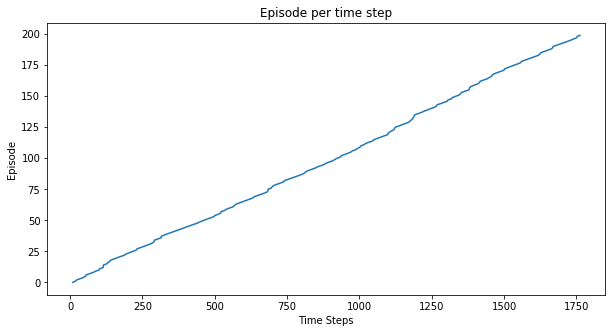

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0020_0.9500


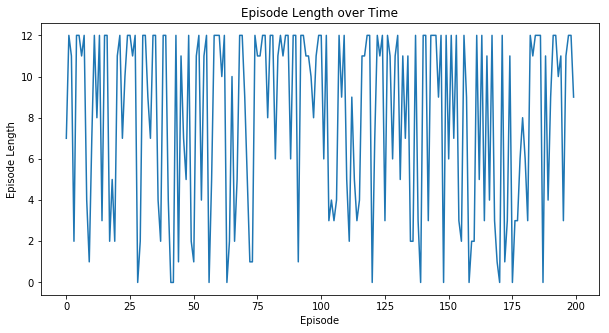

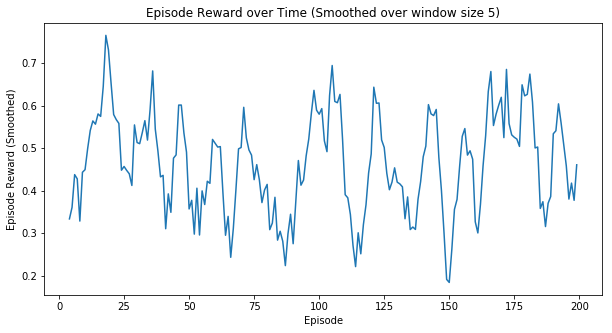

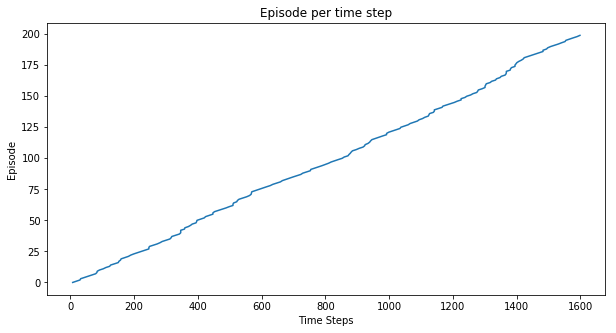

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0020_0.9600


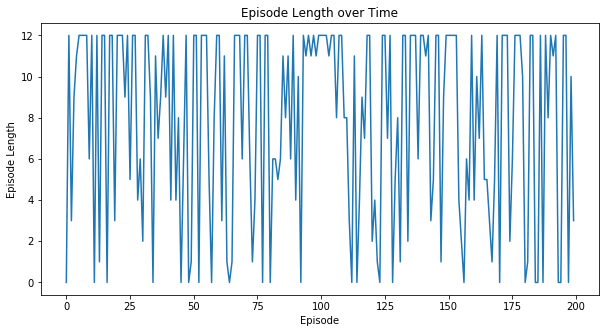

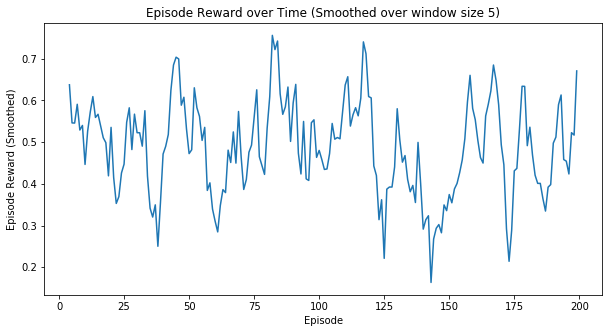

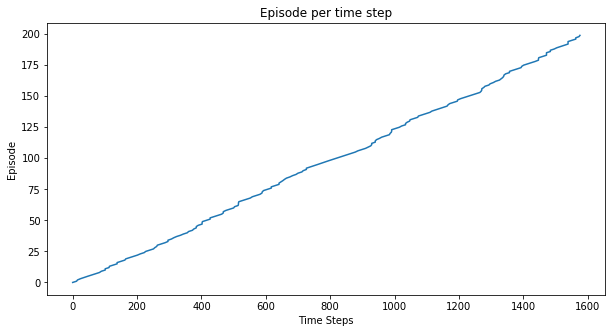

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0020_0.9700


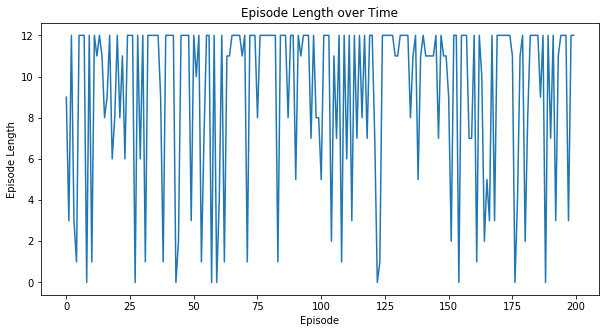

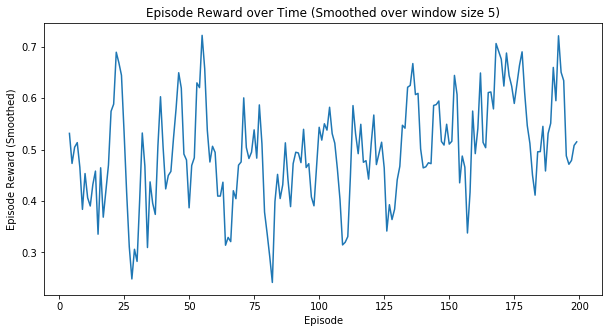

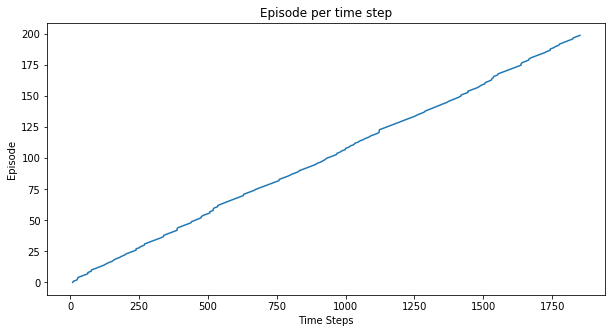

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0200_0.9500


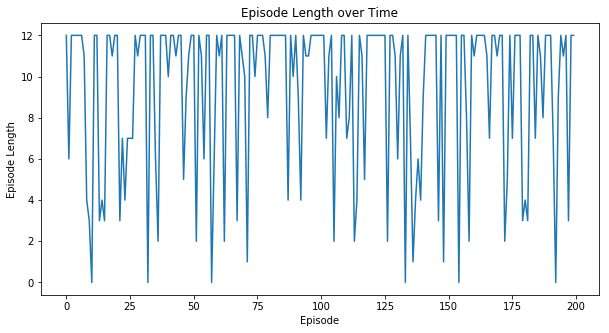

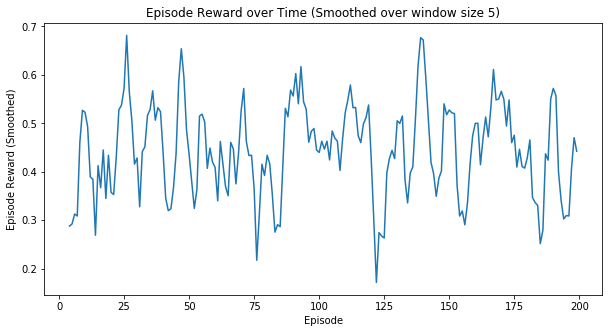

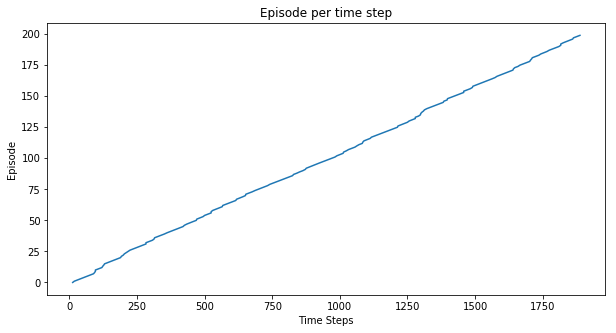

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0200_0.9600


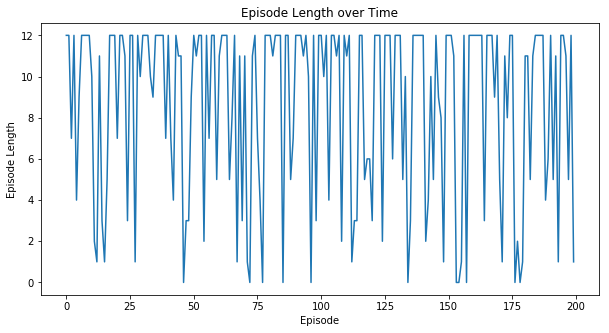

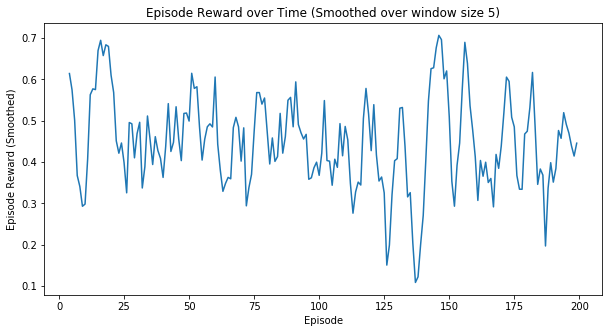

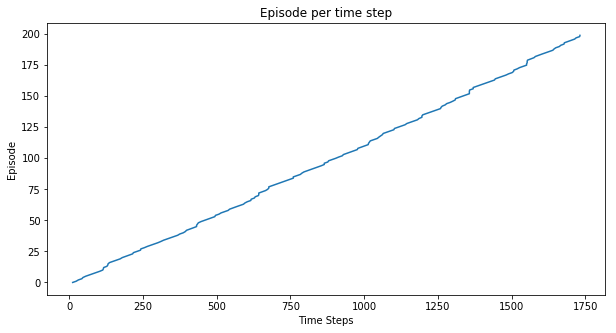

..\session_data_actor_critic\session.data._0.0200_0.9500_0.0200_0.9700


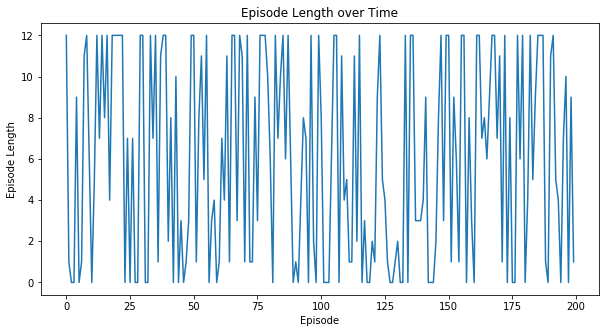

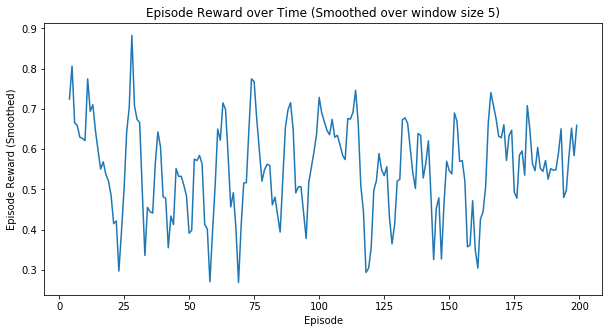

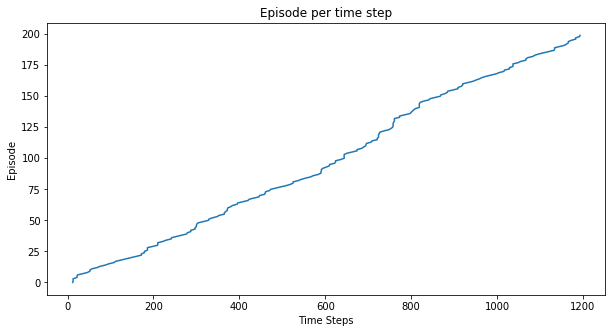

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0020_0.9500


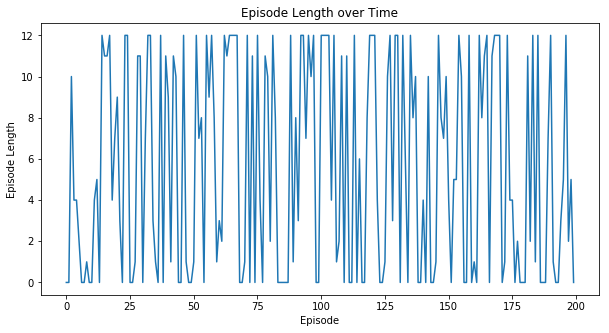

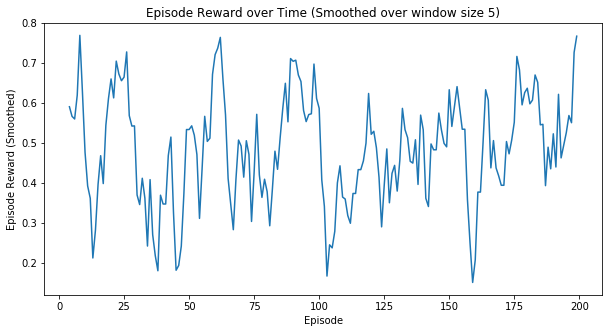

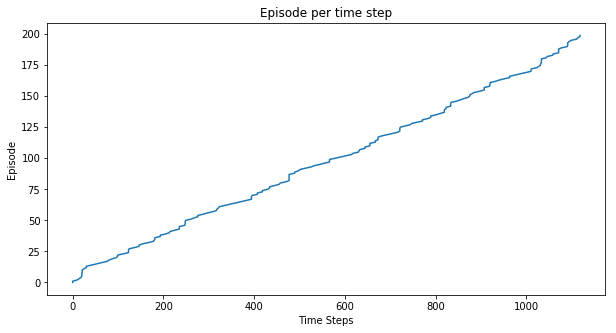

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0020_0.9600


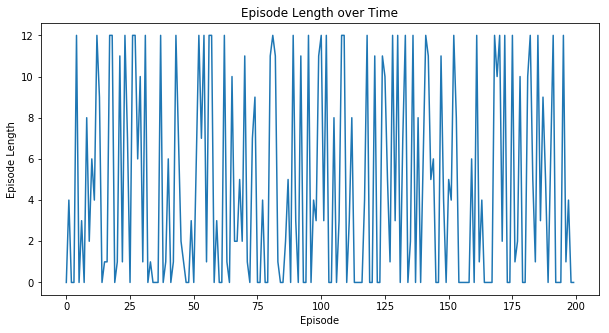

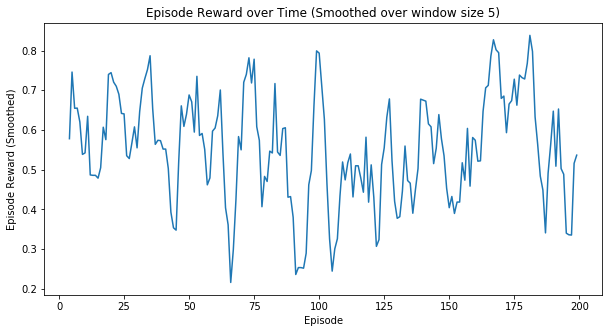

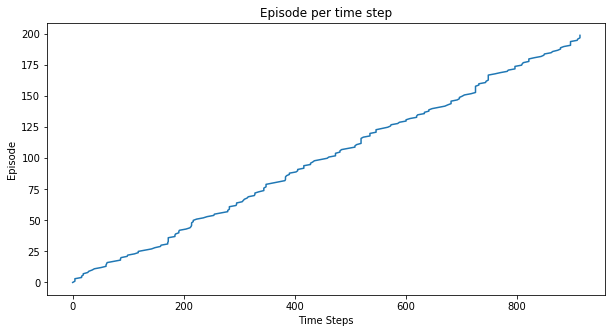

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0020_0.9700


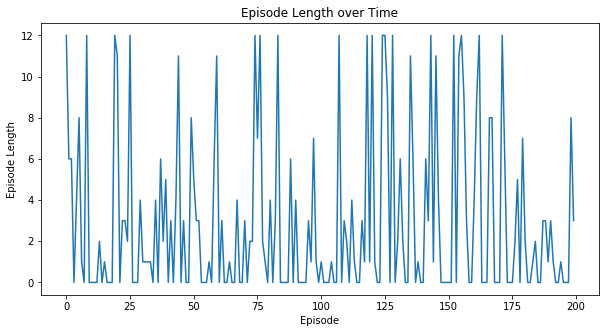

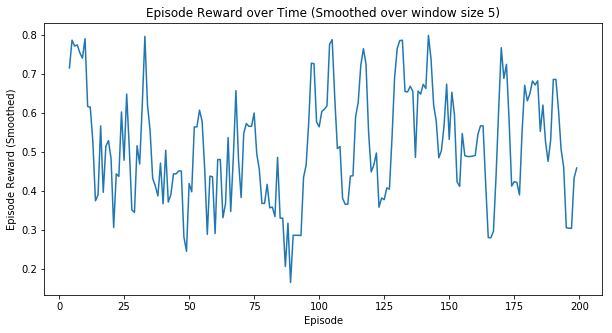

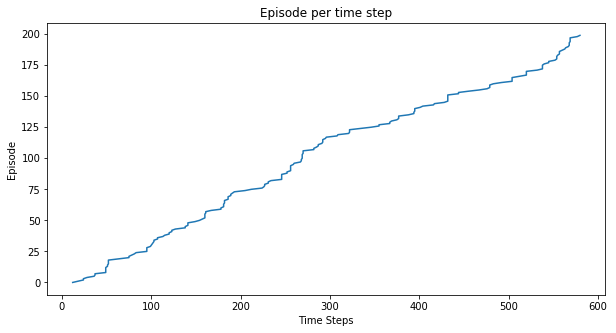

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0200_0.9500


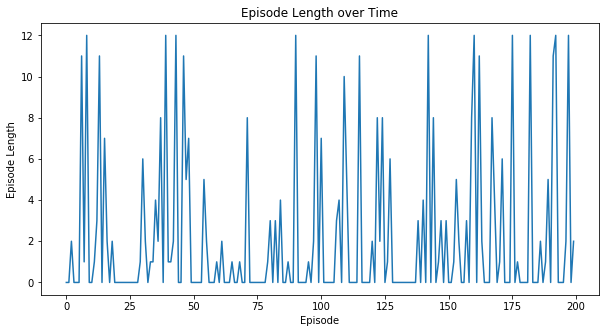

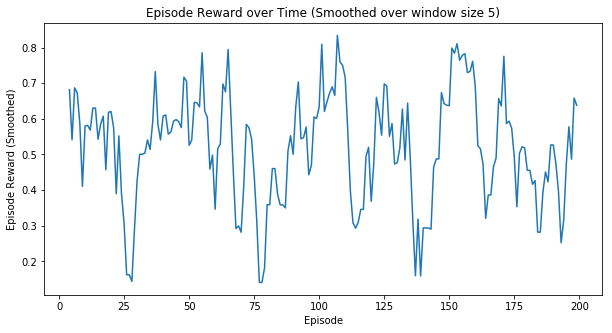

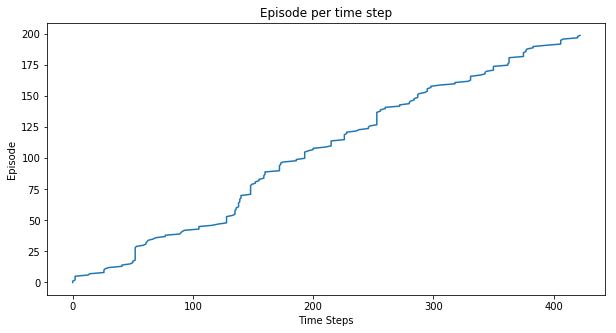

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0200_0.9600


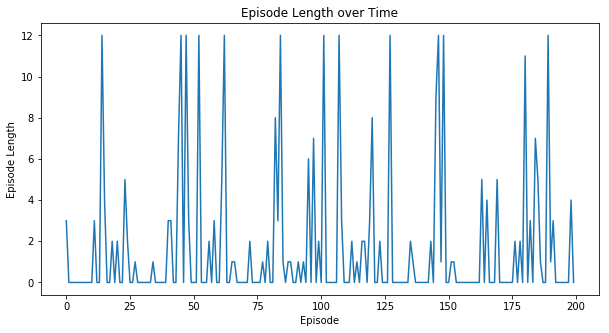

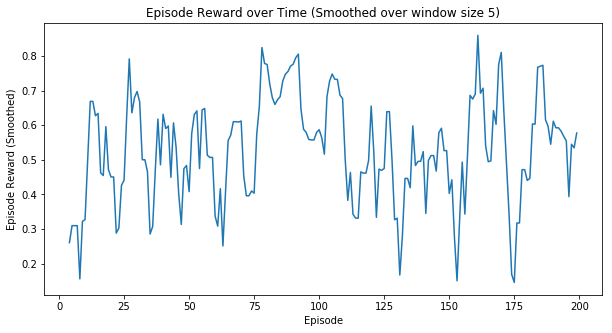

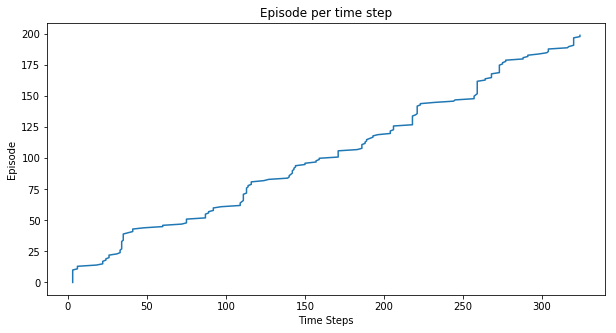

..\session_data_actor_critic\session.data._0.0200_0.9600_0.0200_0.9700


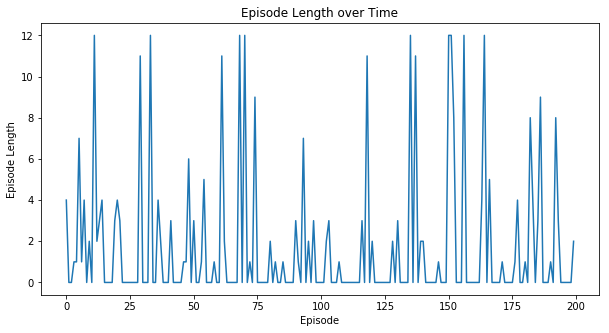

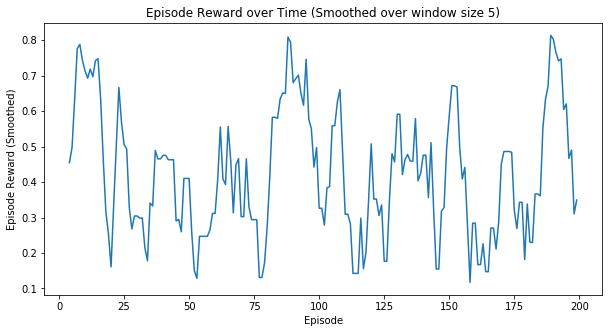

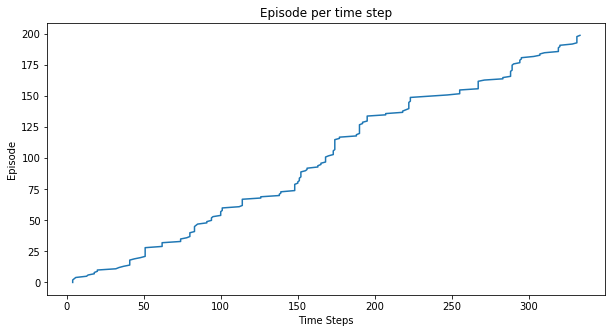

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0020_0.9500


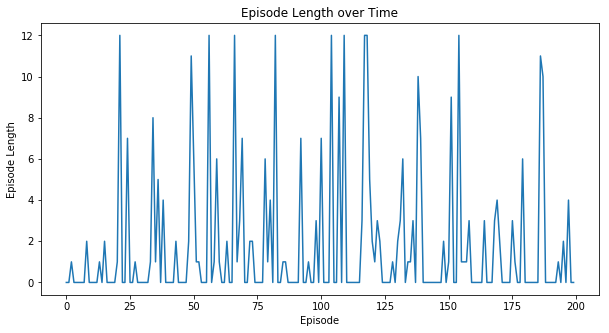

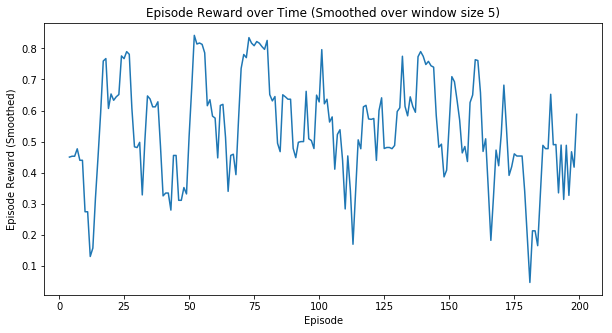

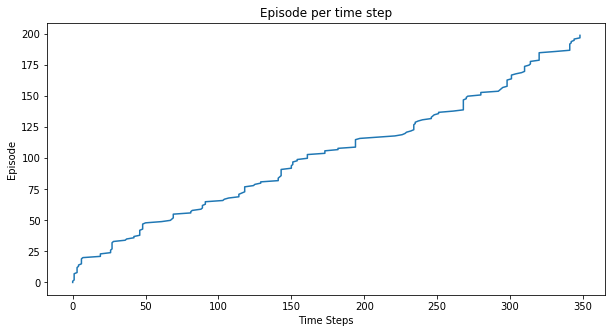

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0020_0.9600


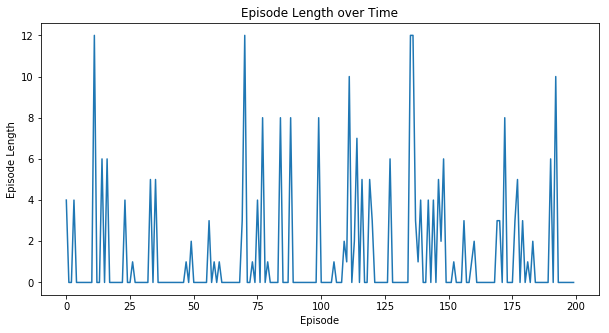

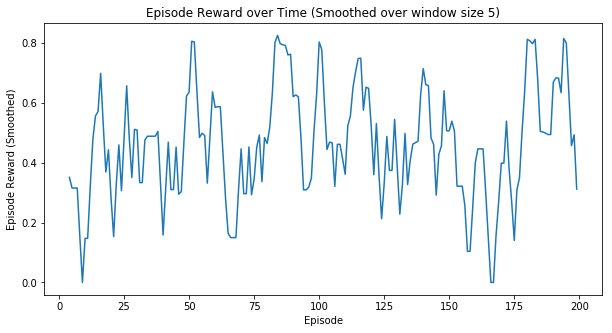

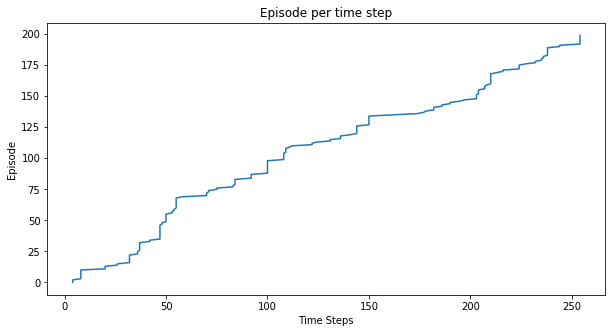

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0020_0.9700


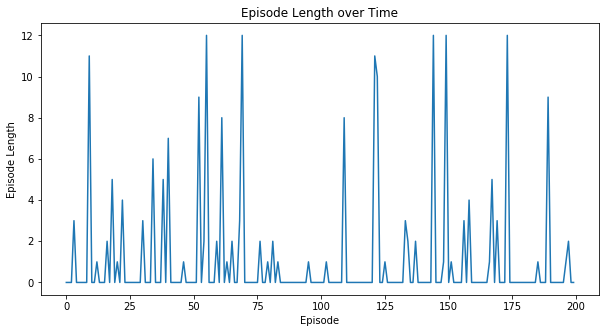

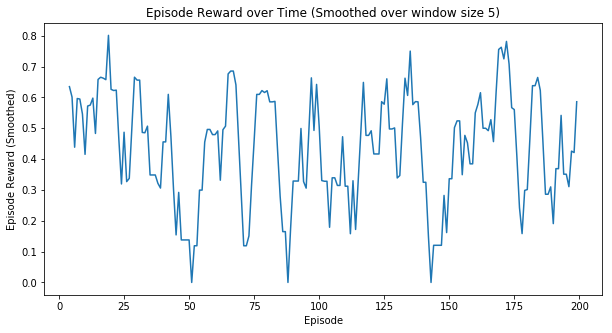

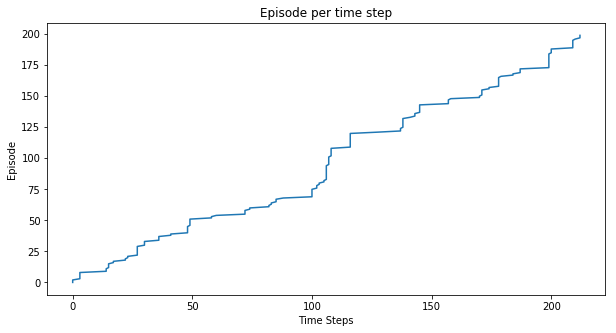

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0200_0.9500


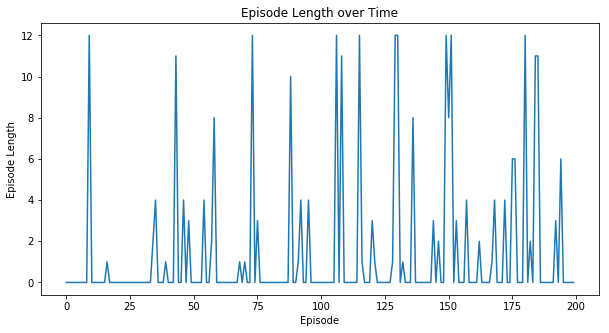

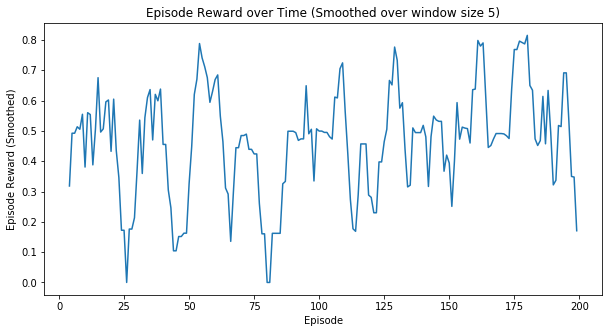

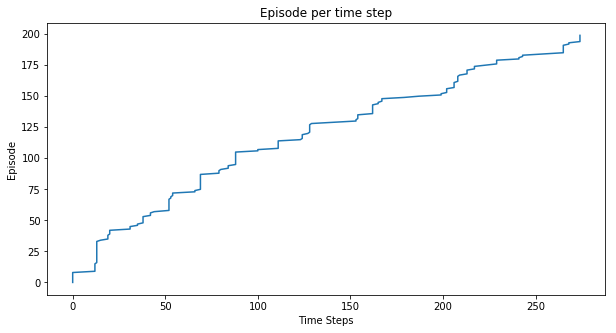

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0200_0.9600


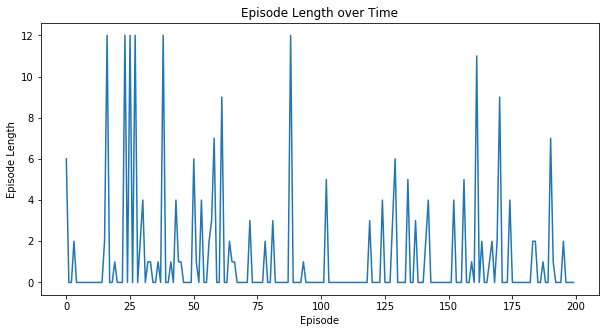

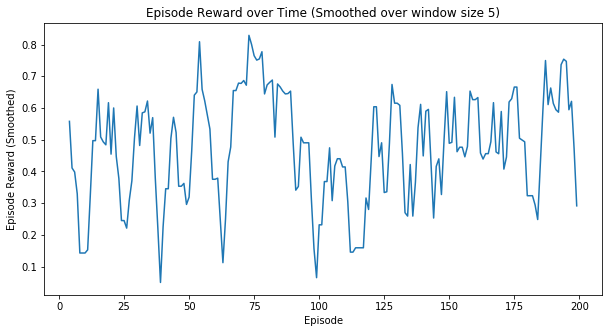

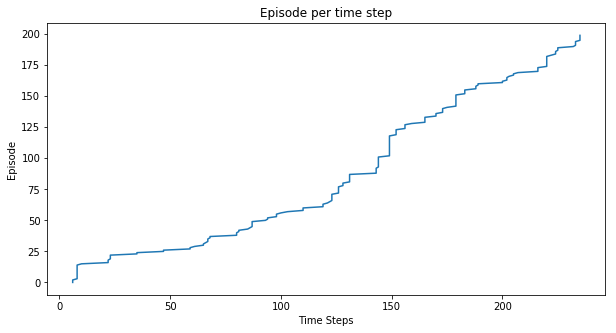

..\session_data_actor_critic\session.data._0.0200_0.9700_0.0200_0.9700


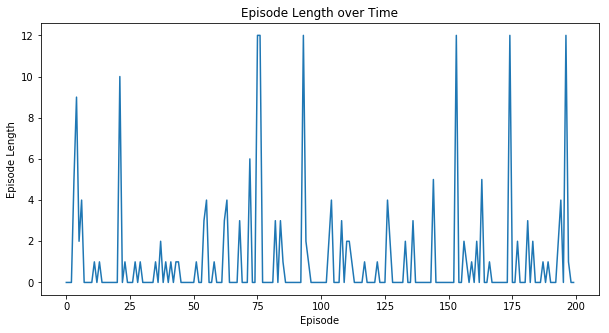

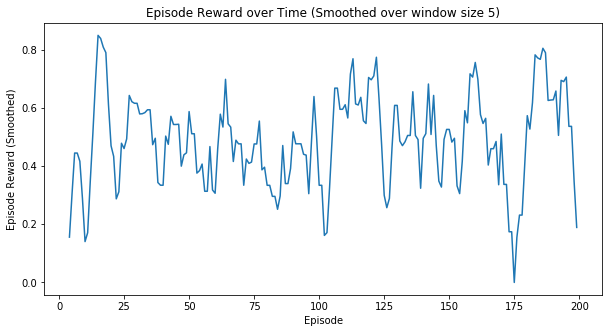

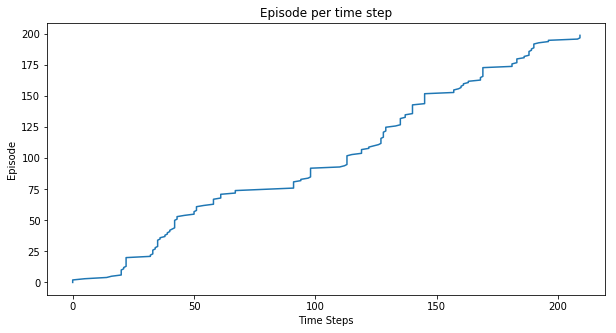

In [268]:
# This looks kind of good
# ..\session_data_actor_critic\session.data._0.0020_0.9500_0.0020_0.9700
for fn in glob.glob('..\session_data_actor_critic\*'):
    print (fn)
    with open(fn, 'rb') as f:
        stats = pickle.load(f, encoding='latin-1')
    plotting.plot_episode_stats(stats, smoothing_window=5)

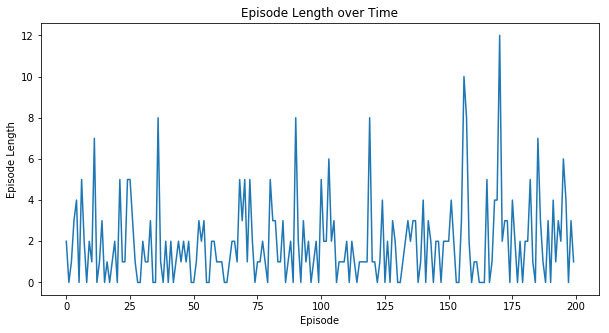

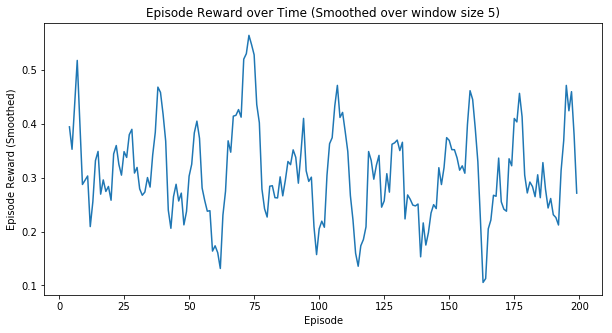

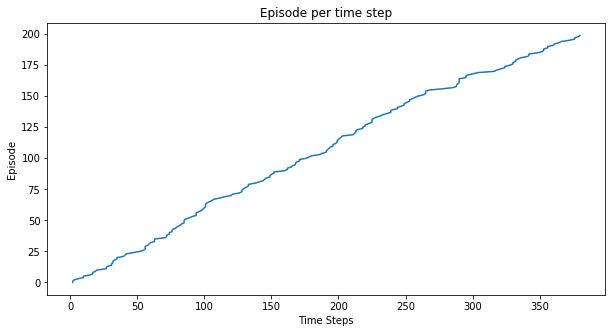

(<matplotlib.figure.Figure at 0x21574d79048>,
 <matplotlib.figure.Figure at 0x2150673a438>)

In [278]:
with open('..\\abc\session.data._0.0020_0.9500_0.0020_0.9600', 'rb') as f:
    stats = pickle.load(f, encoding='latin-1')
plotting.plot_episode_stats(stats, smoothing_window=5)



Text(0.5,1,'Simplest default with labels')

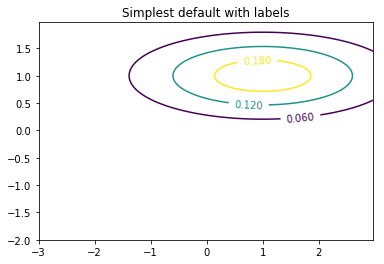

In [296]:
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)

plt.figure()
CS = plt.contour(X, Y, Z2, 3)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')

In [351]:
Z1

array([[ 0.00023928,  0.00025784,  0.00027766, ...,  0.00029881,
         0.00027766,  0.00025784],
       [ 0.00025147,  0.00027097,  0.0002918 , ...,  0.00031404,
         0.0002918 ,  0.00027097],
       [ 0.00026411,  0.0002846 ,  0.00030647, ...,  0.00032983,
         0.00030647,  0.0002846 ],
       ..., 
       [ 0.00027722,  0.00029872,  0.00032168, ...,  0.0003462 ,
         0.00032168,  0.00029872],
       [ 0.00026411,  0.0002846 ,  0.00030647, ...,  0.00032983,
         0.00030647,  0.0002846 ],
       [ 0.00025147,  0.00027097,  0.0002918 , ...,  0.00031404,
         0.0002918 ,  0.00027097]])

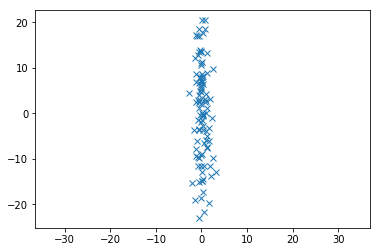

In [389]:
import matplotlib.pyplot as plt

mean = [0, 0]
cov = [[1, 0], [0, 100]]
x, y = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [413]:
a = np.array([2,3])

In [414]:
a ** 2

array([4, 9], dtype=int32)

In [624]:
a = np.array(0)

In [625]:
a

array(0)

In [628]:
print (a.shape)

()
